# Part 3 - Create a dumbbell topology
Create a dumbbell topology as in Fig. 1 (considering all links with a 10 Mb/s
capacity and a propagation delay of 5 ms) and test the behaviour of TCP New Reno,
Vegas, and Cubic as a function of n: how does the congestion window change? How does
the delay change?

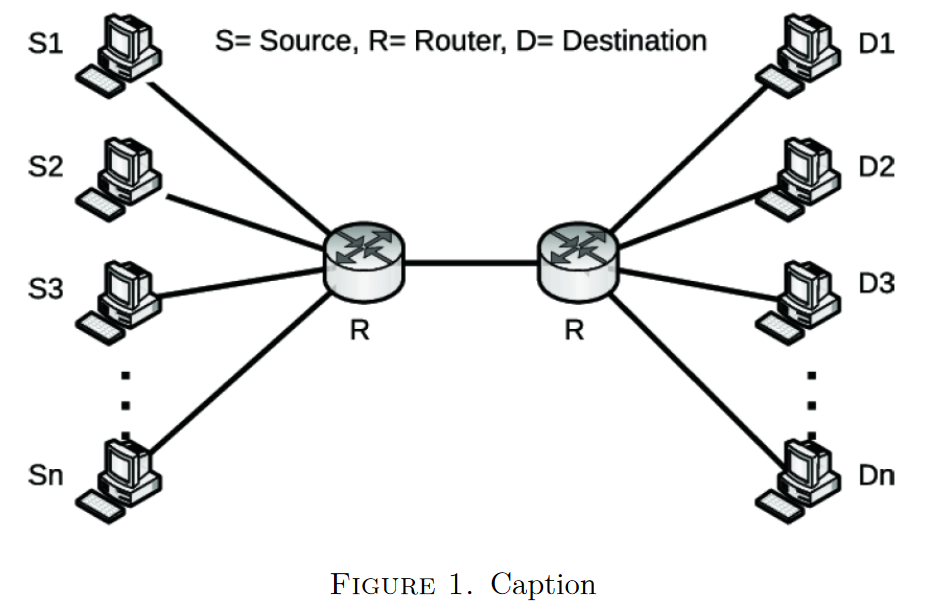
